Please run code in `seurat_pbmc.ipynb` first.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import figure_utils as utils

from truncated_normal import truncated_normal as tn
from scipy.stats import ttest_ind, ranksums, gmean
from sklearn.svm import SVC

%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load data
data_dir = './'
data_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_preprocessed.txt'), delimiter=' ')
labels_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_labels.txt'), delimiter=' ')
tsne_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_tsne.txt'), delimiter=' ')
data = np.array(data_R).T
labels = np.array(labels_R).reshape(-1)
tsne = np.array(tsne_R)
genes = np.array(data_R.index)

tests = [
    "t",
    "wilcox",
    "bimod",
    "tobit",
    "poisson",
    "negbinom",
    "MAST"
]

In [3]:
# Split the datasets
ident0, ident1 = 0, 1
cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamp1.txt'%(ident0, ident1)), delimiter=' ')
pdict = {j:i for i, j in enumerate(data_R.columns)}
cellsamp_inds = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
cellsamp1labels = np.array(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamplabels1.txt'%(ident0, ident1)), delimiter=' ')).reshape(-1)

In [4]:
# get hyperplane using first half of dataset
svm = SVC(kernel='linear', C=100)
svm.fit(data[cellsamp_inds], cellsamp1labels)
a = svm.coef_.reshape(-1)
b = svm.intercept_[0]
labels1hat = svm.predict(data[cellsamp_inds])
print('Consistency of new labels with old: %.3f'\
      %(np.sum(labels1hat == cellsamp1labels)/float(len(cellsamp1labels))))

# assign points in second half of dataset
inds = np.ones(len(data)).astype(bool)
inds[cellsamp_inds] = 0
for i in np.unique(labels):
    if i != 0 and i != 1:
        inds[labels == i] = 0
labels2 = svm.predict(data[inds])
y, z = data[inds][labels2 == 0], data[inds][labels2 == 1]

Consistency of new labels with old: 1.000


In [5]:
# Grab list of genes of interest based on other DE methods
def grab_interesting_de_genes(ident0, ident1):
    genes_list = []
    ngenes = 10
    for i, test in enumerate(tests):
        seurat_de = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_de_%s.txt' \
                                             %(ident0, ident1, test)), delimiter=' ')
        genes_list.extend(list(seurat_de.index[:10]))
    genes_list = np.unique(genes_list)
    return genes_list

# Run TN test on genes that actually change across the two clusters
keep_inds = np.var(np.vstack((y, z)), 0) > 0
y = y[:, keep_inds]
z = z[:, keep_inds]
a = a[keep_inds]

# sweep through iterations
genes_list = grab_interesting_de_genes(ident0, ident1)
genes_to_test = [np.where(genes[keep_inds] == gene)[0][0] for gene in genes_list]
iter_sweep = np.logspace(0, 5, 11).astype(int)

tn_test_multiple_runs = {}
num_sims = 10

picklefile = 'pbmc_seurat_0v1_de_tntest_numiter_sweep.pickle'
if not os.path.isfile(picklefile):
    np.random.seed(0)
    for j in range(num_sims):
        for num_iters in iter_sweep:
            p_tn, likelihood = tn.tn_test(y, z, a=a, b=b, verbose=True, learning_rate=0.5,
                                          eps=1e-1, genes_to_test=genes_to_test,
                                          return_likelihood=True, num_iters=num_iters)
            tn_test_multiple_runs[(num_iters, j)] = (p_tn, likelihood[-1])
    pickle.dump(tn_test_multiple_runs, open(picklefile, 'wb'))
else:
    tn_test_multiple_runs = pickle.load(open(picklefile, 'rb'))

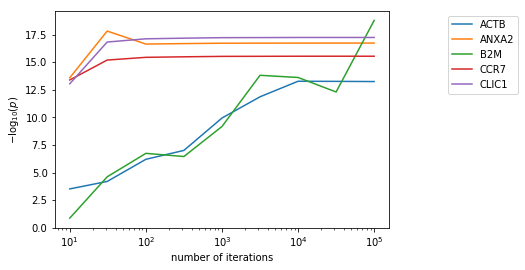

In [6]:
# Collapse multiple runs into one
plot_results = []
for num_iters in iter_sweep:
    runs = [tn_test_multiple_runs[(num_iters, j)] for j in range(num_sims)]
    p_tn, likelihood = sorted(runs, key = lambda x:x[1])[-1]
    plot_results.append(p_tn)
    
# Collapse multiple runs into one
plot_results = []
for num_iters in iter_sweep:
    runs = [tn_test_multiple_runs[(num_iters, j)] for j in range(num_sims) 
            if not np.isinf(tn_test_multiple_runs[(num_iters, j)][1])]
    p_tn, likelihood = sorted(runs, key = lambda x:x[1])[-1]
    plot_results.append(p_tn)

for i in range(5):
    curve = [-np.log10(result[i]) for result in plot_results]
    plt.plot(iter_sweep[2:], curve[2:], label=genes_list[i])
plt.xscale('log')
plt.xlabel('number of iterations')
plt.ylabel(r'$-\log_{10}(p)$')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.savefig('figures/pbmc_%sv%s_num_iters.pdf'%(ident0, ident1), format='pdf', dpi=500, bbox_inches='tight')
plt.show()    

# Testing other clusters

In [7]:
def load_and_split_data(ident0, ident1, save=True):
    cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamp1.txt'%(ident0, ident1)), delimiter=' ')
    pdict = {j:i for i, j in enumerate(data_R.columns)}
    cellsamp_inds = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
    cellsamp1labels = np.array(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamplabels1.txt'%(ident0, ident1)), delimiter=' ')).reshape(-1)

    # get hyperplane using first half of dataset
    svm = SVC(kernel='linear', C=100)
    svm.fit(data[cellsamp_inds], cellsamp1labels)
    a = svm.coef_.reshape(-1)
    b = svm.intercept_[0]
    labels1hat = svm.predict(data[cellsamp_inds])
    print('Consistency of new labels with old: %.3f'\
          %(np.sum(labels1hat == cellsamp1labels)/float(len(cellsamp1labels))))

    # assign points in second half of dataset
    inds = np.ones(len(data)).astype(bool)
    inds[cellsamp_inds] = 0
    for i in np.unique(labels):
        if i != ident0 and i != ident1:
            inds[labels == i] = 0
    labels2 = svm.predict(data[inds])
    y, z = data[inds][labels2 == 0], data[inds][labels2 == 1]

    if save:
        np.savetxt('pbmc_seurat_%sv%s_cellsamp2.txt'%(ident0, ident1), data_R.columns[inds], fmt='%s')
        np.savetxt('pbmc_seurat_%sv%s_cellsamplabels2.txt'%(ident0, ident1), labels2, fmt='%s')
    
    return y, z, a, b


def compare_clusters_multiple_runs_less_genes(ident0, ident1, num_runs=10):
    """Set up and run TN test data splitting framework
        run TN test multiple times to account for variance in optimization
        use less genes to save computation
    """
    
    picklefile = 'pbmc_seurat_%sv%s_de_tntest_multiple_runs_max_withseed.pickle'%(ident0, ident1)
    if os.path.isfile(picklefile):
        tn_test_multiple_runs = pickle.load(open(picklefile, 'rb'))
        p_tn, likelihood, seed = sorted(tn_test_multiple_runs, key = lambda x:x[1])[-1]
        return p_tn
    
    y, z, a, b = load_and_split_data(ident0, ident1)

    # Run TN test on genes that actually change across the two clusters
    keep_inds = np.var(np.vstack((y, z)), 0) > 0
    np.savetxt('pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1), keep_inds)
    y = y[:, keep_inds]
    z = z[:, keep_inds]
    a = a[keep_inds]

    genes_list = grab_interesting_de_genes(ident0, ident1)
    genes_to_test = [np.where(genes[keep_inds] == gene)[0][0] for gene in genes_list]

    # Run TN test multiple times to evaluate stability
    tn_test_multiple_runs = []
    num_runs = 10
    for _ in range(num_runs):
        seed = np.random.get_state()
        p_tn, likelihood = tn.tn_test(y, z, a=a, b=b, verbose=True, learning_rate=0.5,
                                      eps=1e-1, genes_to_test=genes_to_test,
                                      return_likelihood=True)
        tn_test_multiple_runs.append((p_tn, likelihood[-1], seed))
    pickle.dump(tn_test_multiple_runs, open(picklefile, 'wb'))
    
    p_tn, likelihood, seed = sorted(tn_test_multiple_runs, key = lambda x:x[1])[-1]
    return p_tn


def compare_clusters_tn_test(ident0, ident1):
    """Set up and run TN test data splitting framework"""

    picklefile = 'pbmc_seurat_%sv%s_de_tntest_all_genes.pickle'%(ident0, ident1)
    if os.path.isfile(picklefile):
        return pickle.load(open(picklefile, 'rb'))

    y, z, a, b = load_and_split_data(ident0, ident1)

    # Run TN test on genes that actually change across the two clusters
    keep_inds = np.var(np.vstack((y, z)), 0) > 0
    np.savetxt('pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1), keep_inds)
    y = y[:, keep_inds]
    z = z[:, keep_inds]
    a = a[keep_inds]
    
    # Get seed based on previous experiment
    seedfile = 'pbmc_seurat_%sv%s_de_tntest_multiple_runs_max_withseed.pickle'%(ident0, ident1)
    tn_test_multiple_runs = pickle.load(open(seedfile, 'rb'))
    _, _, seed = sorted(tn_test_multiple_runs, key = lambda x:x[1])[-1]
    np.random.set_state(seed)

    # Run TN test multiple times to evaluate stability
    p_tn, likelihood = tn.tn_test(y, z, a=a, b=b, verbose=True, learning_rate=0.5,
                                  eps=1e-1, return_likelihood=True, num_iters=10000, num_cores=64)
    pickle.dump(p_tn, open(picklefile, 'wb'))

    return p_tn, likelihood[-1]


def plot_bar_p(gene_names, p_correct, p_seurat=None, label=None, width=0.35,
               set_ylabel=True, p_tn_se=None, mark_red=[]):
    fig, ax = plt.subplots(figsize=(3, 1.5))
    ind = np.arange(len(p_correct))
    if p_seurat is not None:
        rects = ax.bar(ind-0.2,
                       p_seurat, width,
                       align='center',
                       label=label)
        rects = ax.bar(ind-0.2+0.3,
                       p_correct, width,
                       yerr=p_tn_se,
                       align='center',
                       label='TN test')
    else:
        rects = ax.bar(ind,
                       p_correct, width,
                       yerr=p_tn_se,
                       align='center',
                       label='TN test',
                       color='#ff7f0e')
    if set_ylabel: ax.set_ylabel('-log($p$)')
    xticks_pos = [0.65*patch.get_width()+patch.get_xy()[0]-0.1 for patch in rects]
    plt.xticks(np.array(xticks_pos), gene_names, rotation=90)
    for ticklabel in plt.gca().get_xticklabels():
        if ticklabel.get_text() in mark_red:
            ticklabel.set_color('r')
    plt.legend()     

        
def get_de_df(ident0, ident1):
    genes_list = grab_interesting_de_genes(ident0, ident1)
    df_dict = {'TN': list(-np.log10(np.max(tn_test_multiple_runs, axis=0)))}
    for i, test in enumerate(tests):
        seurat_de = -np.log10(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_de_%s.txt'%(ident0, ident1, test)), delimiter=' '))
        df_dict[test] = list(seurat_de.loc[genes_list]['p_val'])
    de_df = pd.DataFrame.from_dict(df_dict).set_index(genes_list).round(2)
    interesting_genes = genes_list[np.argmin(np.array(de_df), 1) == 0]
    return de_df, interesting_genes


def view_genes(gene_names, ident0, ident1, marked_genes=None):
    
    labels1 = np.array(pd.read_csv('./pbmc_seurat_%sv%s_cellsamplabels1.txt'%(ident0, ident1), delimiter=' ')).reshape(-1)
    labels2 = np.loadtxt('./pbmc_seurat_%sv%s_cellsamplabels2.txt'%(ident0, ident1))

    cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_cellsamp1.txt'%(ident0, ident1)), delimiter=' ')
    pdict = {j:i for i, j in enumerate(data_R.columns)}
    inds1 = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
    cellsamp2 = np.loadtxt('./pbmc_seurat_%sv%s_cellsamp2.txt'%(ident0, ident1), dtype='str')
    inds2 = np.array([pdict[i] for i in np.array(cellsamp2).reshape(-1)])

    data1 = data[inds1]
    data2 = data[inds2]

    y1, z1 = data1[labels1 == 0], data1[labels1 == 1]
    y2, z2 = data2[labels2 == 0], data2[labels2 == 1]
    
    for i, gene_name in enumerate(gene_names):
        if i%4 == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
            plt.figure(figsize=(2*4, 1.8))
        plt.subplot(1, 4, i%4+1)
        g_ind = np.where(genes == gene_name)[0][0]
        utils.plot_stacked_hist(np.vstack((y1, y2))[:, g_ind], np.vstack((z1, z2))[:, g_ind])
        plt.title(gene_name+('*' if gene_name in marked_genes else ''))
        plt.axis('off')
        print('%10s | type %s with mean %.2f'%(gene_name, ident0, np.mean(data[labels == ident0, g_ind])))
        print('%10s | type %s with mean %.2f'%(gene_name, ident1, np.mean(data[labels == ident1, g_ind])))

    plt.tight_layout()
    
    
def create_and_save_visualization(p_tn, ident0, ident1, genes_to_view, genes_to_mark_red=[], ngenes=5):
    plt.savefig('figures/pbmc_%sv%s_multiple_runs_gene_exp.pdf'\
                %(ident0, ident1), format='pdf', dpi=500, bbox_inches='tight')
    
    
    filename = 'pbmc_seurat_%sv%s_filtered_genes.txt'%(ident0, ident1)
    genes_tn = np.array(data_R.index)[np.loadtxt(filename).astype(bool)]
    
    if genes_to_view is None:
        genes_to_view = grab_interesting_de_genes(ident0, ident1)
    
    view_genes(genes_to_view, ident0, ident1, marked_genes=[])
    plt.savefig('figures/pbmc_%sv%s_gene_exp.pdf'%(ident0, ident1), format='pdf', dpi=500, bbox_inches='tight')

    for i, test in enumerate(tests):
        seurat_de = -np.log10(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_%sv%s_de_%s.txt' \
                                                       %(ident0, ident1, test)), delimiter=' '))
        del seurat_de['avg_logFC']
        del seurat_de['pct.1']
        del seurat_de['pct.2']
        del seurat_de['p_val_adj']
        gene_names = seurat_de.index[:ngenes]
        p_seurat = seurat_de['p_val'][:ngenes]
        p_correct = [-np.log10(p_tn)[genes_tn == gene][0] for gene in gene_names][:ngenes]
        if test == "t": 
            test = 'Welch\'s $t$'
        plot_bar_p(gene_names, p_correct, p_seurat=p_seurat, label=test,
                   set_ylabel = True if i == 0 or i == 4 else False, mark_red=genes_to_mark_red)
        plt.savefig('figures/pbmc_de_%sv%s_%s.pdf'%(ident0, ident1, test), format='pdf', dpi=500, bbox_inches='tight')
        
        print(test)
        for j in range(ngenes):
            print('%10s\tpDE: %.2f\tpTN: %.2f'%(gene_names[j], p_seurat[j],  p_correct[j]))
        print(' ')

    inds = np.argsort(p_tn)[:ngenes]
    p_correct = -np.log10(p_tn)[inds]
    gene_names = genes_tn[inds]
    plot_bar_p(gene_names, p_correct, set_ylabel=False)
    plt.savefig('figures/pbmc_de_%sv%s_tn.pdf'%(ident0, ident1), format='pdf', dpi=500, bbox_inches='tight')
    plt.show()
    
    
def tsne_select2(ident0, ident1):
    labels_ = np.array(labels).astype(str)
    labels_[~((labels == ident0) | (labels == ident1))] = 'Other'
    plt.scatter(tsne[labels_ == str(ident0), 0], tsne[labels_ == str(ident0), 1],
                label=r'c%s ($n$ = %s)'%(ident0, np.sum(labels_== str(ident0))), c='g', s=10)
    plt.scatter(tsne[labels_ == str(ident1), 0], tsne[labels_ == str(ident1), 1],
                label=r'c%s ($n$ = %s)'%(ident1, np.sum(labels_== str(ident1))), c='r', s=10)
    plt.scatter(tsne[labels_ == 'Other', 0], tsne[labels_ == 'Other', 1],
                label=r'Other ($n$ = %s)'%(np.sum(labels_=='Other')), c='k', s=10)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.axis('equal')
    plt.axis('off')
    plt.savefig('figures/pbmc_tsne_%sv%s.pdf'%(ident0, ident1),
                    format='pdf', dpi=500, bbox_inches='tight')
    plt.show()    

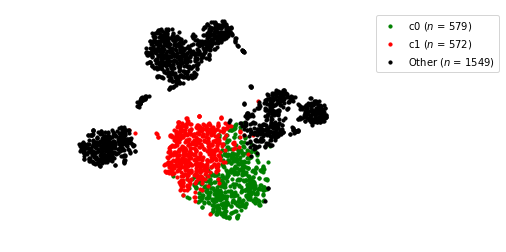

    S100A4 | type 0 with mean 2.63
    S100A4 | type 1 with mean 1.73
   S100A11 | type 0 with mean 1.11
   S100A11 | type 1 with mean 0.55
       B2M | type 0 with mean 5.33
       B2M | type 1 with mean 5.06
     HLA-A | type 0 with mean 3.38
     HLA-A | type 1 with mean 3.07


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in log10


Welch's $t$
    S100A4	pDE: 43.37	pTN: 70.27
       B2M	pDE: 24.36	pTN: 12.43
      IL32	pDE: 23.39	pTN: 21.98
     CLIC1	pDE: 16.21	pTN: 17.24
    LGALS1	pDE: 15.68	pTN: 23.11
  SH3BGRL3	pDE: 15.12	pTN: 23.56
     ANXA2	pDE: 14.12	pTN: 16.73
   S100A11	pDE: 13.61	pTN: 26.50
      CCR7	pDE: 13.32	pTN: 15.54
   S100A10	pDE: 13.17	pTN: 22.38
 
wilcox
    S100A4	pDE: 40.84	pTN: 70.27
       B2M	pDE: 29.07	pTN: 12.43
      IL32	pDE: 22.11	pTN: 21.98
  SH3BGRL3	pDE: 17.16	pTN: 23.56
     HLA-A	pDE: 16.42	pTN: 7.14
     CLIC1	pDE: 15.98	pTN: 17.24
    LGALS1	pDE: 15.29	pTN: 23.11
     ANXA2	pDE: 13.94	pTN: 16.73
   S100A11	pDE: 13.75	pTN: 26.50
     RPS3A	pDE: 13.42	pTN: 14.30
 
bimod
    S100A4	pDE: 44.58	pTN: 70.27
       B2M	pDE: 22.48	pTN: 12.43
      IL32	pDE: 22.19	pTN: 21.98
    LGALS1	pDE: 20.50	pTN: 23.11
  SH3BGRL3	pDE: 15.65	pTN: 23.56
     HLA-A	pDE: 15.16	pTN: 7.14
     CLIC1	pDE: 14.59	pTN: 17.24
   S100A11	pDE: 14.01	pTN: 26.50
     ANXA2	pDE: 13.78	pTN: 16.73
      CCR7	pDE: 

<Figure size 432x288 with 0 Axes>

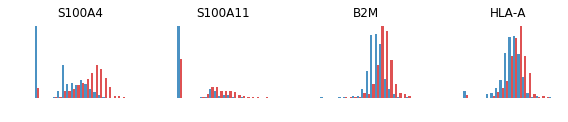

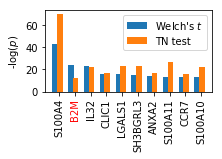

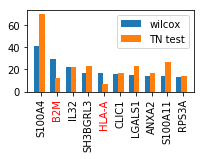

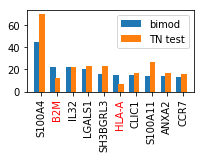

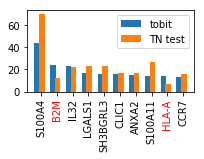

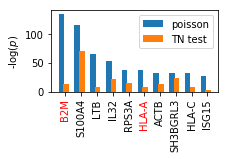

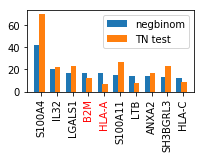

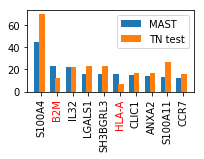

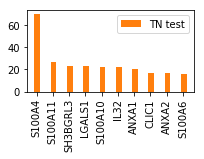

In [8]:
np.random.seed(0)
ident0, ident1 = 0, 1
_ = compare_clusters_multiple_runs_less_genes(ident0, ident1)
p_tn = compare_clusters_tn_test(ident0, ident1)

ngenes = 10
genes_to_view = ['S100A4', 'S100A11', 'B2M', 'HLA-A']
genes_to_mark_red = ['B2M', 'HLA-A']
tsne_select2(ident0, ident1)
create_and_save_visualization(p_tn, ident0, ident1, genes_to_view,
                              genes_to_mark_red=genes_to_mark_red, ngenes=ngenes)

      ACTB | type 1 with mean 3.51
      ACTB | type 3 with mean 4.13
       B2M | type 1 with mean 5.06
       B2M | type 3 with mean 5.60
      CCL5 | type 1 with mean 0.34
      CCL5 | type 3 with mean 3.58
      CCR7 | type 1 with mean 0.86
      CCR7 | type 3 with mean 0.08


<Figure size 432x288 with 0 Axes>

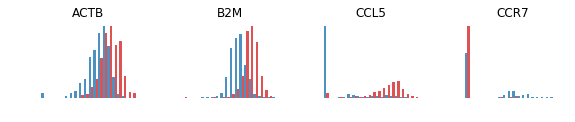

      CST7 | type 1 with mean 0.07
      CST7 | type 3 with mean 1.89
      CTSW | type 1 with mean 0.55
      CTSW | type 3 with mean 1.97
      GZMA | type 1 with mean 0.10
      GZMA | type 3 with mean 1.93
      GZMH | type 1 with mean 0.03
      GZMH | type 3 with mean 1.11


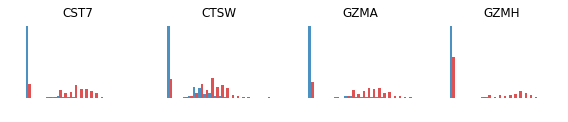

     HLA-C | type 1 with mean 3.16
     HLA-C | type 3 with mean 3.93
      NKG7 | type 1 with mean 0.21
      NKG7 | type 3 with mean 3.30
     RPL13 | type 1 with mean 5.08
     RPL13 | type 3 with mean 4.71
    RPL13A | type 1 with mean 5.03
    RPL13A | type 3 with mean 4.72


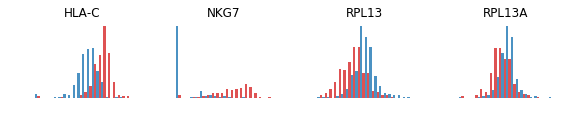

     RPL32 | type 1 with mean 4.71
     RPL32 | type 3 with mean 4.15
     RPS12 | type 1 with mean 4.67
     RPS12 | type 3 with mean 4.21
     RPS27 | type 1 with mean 4.60
     RPS27 | type 3 with mean 4.19
     RPS3A | type 1 with mean 4.32
     RPS3A | type 3 with mean 3.86


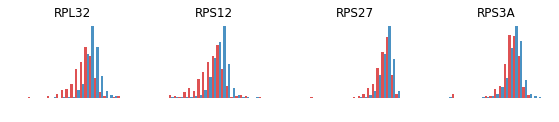

      RPS6 | type 1 with mean 4.90
      RPS6 | type 3 with mean 4.50
    S100A4 | type 1 with mean 1.73
    S100A4 | type 3 with mean 2.97
      SRGN | type 1 with mean 0.66
      SRGN | type 3 with mean 1.61


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in log10


Welch's $t$
      NKG7	pDE: 74.84	pTN: 268.90
      CCL5	pDE: 73.15	pTN: 157.59
      CST7	pDE: 43.15	pTN: 177.53
      GZMA	pDE: 41.45	pTN: 132.24
      CTSW	pDE: 35.67	pTN: 41.93
     HLA-C	pDE: 32.53	pTN: 33.71
       B2M	pDE: 29.33	pTN: 34.44
      CCR7	pDE: 26.86	pTN: 18.63
    S100A4	pDE: 25.75	pTN: 25.19
     RPS12	pDE: 25.61	pTN: 28.52
 
wilcox
      NKG7	pDE: 65.70	pTN: 268.90
      CST7	pDE: 54.08	pTN: 177.53
      CCL5	pDE: 50.13	pTN: 157.59
      GZMA	pDE: 47.73	pTN: 132.24
     HLA-C	pDE: 37.74	pTN: 33.71
      CTSW	pDE: 36.15	pTN: 41.93
       B2M	pDE: 35.06	pTN: 34.44
     RPS12	pDE: 34.62	pTN: 28.52
     RPL32	pDE: 32.74	pTN: 46.57
      GZMH	pDE: 31.50	pTN: 59.02
 
bimod
      NKG7	pDE: 76.86	pTN: 268.90
      CCL5	pDE: 60.51	pTN: 157.59
      CST7	pDE: 53.77	pTN: 177.53
      GZMA	pDE: 47.08	pTN: 132.24
     RPL32	pDE: 40.99	pTN: 46.57
     HLA-C	pDE: 40.89	pTN: 33.71
     RPS12	pDE: 40.69	pTN: 28.52
      CTSW	pDE: 39.62	pTN: 41.93
      SRGN	pDE: 36.89	pTN: 26.93
  

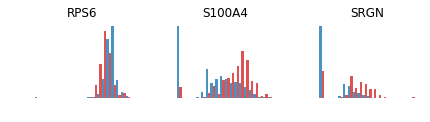

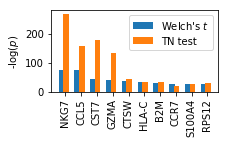

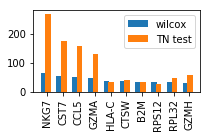

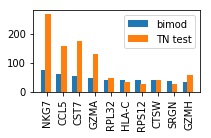

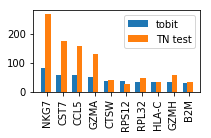

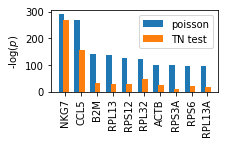

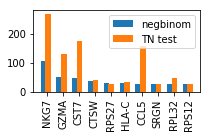

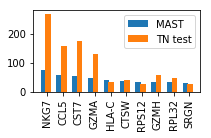

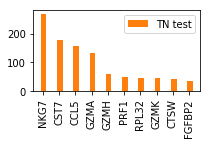

In [9]:
np.random.seed(0)
ident0, ident1 = 1, 3
_ = compare_clusters_multiple_runs_less_genes(ident0, ident1)
p_tn = compare_clusters_tn_test(ident0, ident1)

create_and_save_visualization(p_tn, ident0, ident1, None, ngenes=10)

     ALDH2 | type 2 with mean 0.87
     ALDH2 | type 5 with mean 0.30
       B2M | type 2 with mean 4.73
       B2M | type 5 with mean 5.13
     BLVRB | type 2 with mean 1.11
     BLVRB | type 5 with mean 0.49
     CD79B | type 2 with mean 0.11
     CD79B | type 5 with mean 0.91


<Figure size 432x288 with 0 Axes>

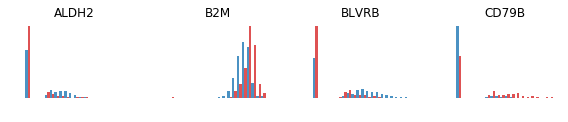

    FCGR3A | type 2 with mean 0.16
    FCGR3A | type 5 with mean 2.49
      FCN1 | type 2 with mean 3.02
      FCN1 | type 5 with mean 2.18
      FTH1 | type 2 with mean 5.31
      FTH1 | type 5 with mean 5.64
      GPX1 | type 2 with mean 2.67
      GPX1 | type 5 with mean 1.30


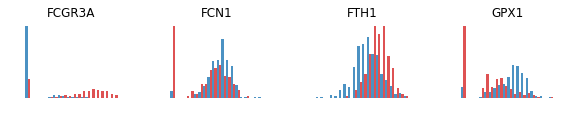

     GSTP1 | type 2 with mean 2.67
     GSTP1 | type 5 with mean 1.59
    IFITM2 | type 2 with mean 1.43
    IFITM2 | type 5 with mean 3.25
      LST1 | type 2 with mean 2.85
      LST1 | type 5 with mean 3.74
       LYZ | type 2 with mean 5.14
       LYZ | type 5 with mean 3.39


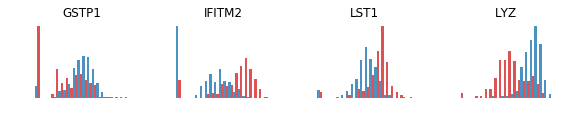

    MALAT1 | type 2 with mean 4.51
    MALAT1 | type 5 with mean 4.87
    MS4A6A | type 2 with mean 1.57
    MS4A6A | type 5 with mean 0.41
      RHOC | type 2 with mean 0.22
      RHOC | type 5 with mean 1.65
     RPS19 | type 2 with mean 3.56
     RPS19 | type 5 with mean 4.42


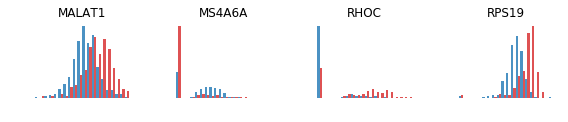

    S100A8 | type 2 with mean 4.07
    S100A8 | type 5 with mean 1.30
    S100A9 | type 2 with mean 4.67
    S100A9 | type 5 with mean 2.37
    TMSB4X | type 2 with mean 5.45
    TMSB4X | type 5 with mean 5.65


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:189: RuntimeWarning: invalid value encountered in log10


Welch's $t$
       LYZ	pDE: 24.21	pTN: 76.24
    FCGR3A	pDE: 22.10	pTN: 152.40
    S100A9	pDE: 19.38	pTN: 70.59
    IFITM2	pDE: 18.60	pTN: 43.60
      GPX1	pDE: 17.89	pTN: 37.33
    S100A8	pDE: 15.53	pTN: 82.35
     BLVRB	pDE: 14.68	pTN: 12.26
    MS4A6A	pDE: 14.19	pTN: 24.11
     ALDH2	pDE: 13.94	pTN: 4.90
     GSTP1	pDE: 13.35	pTN: 28.54
 
wilcox
       LYZ	pDE: 26.51	pTN: 76.24
    FCGR3A	pDE: 26.34	pTN: 152.40
    IFITM2	pDE: 20.34	pTN: 43.60
    S100A9	pDE: 20.07	pTN: 70.59
      GPX1	pDE: 18.87	pTN: 37.33
     RPS19	pDE: 18.15	pTN: 30.40
      RHOC	pDE: 15.33	pTN: 47.52
    S100A8	pDE: 14.57	pTN: 82.35
     CD79B	pDE: 14.49	pTN: 22.88
     GSTP1	pDE: 14.22	pTN: 28.54
 
bimod
       LYZ	pDE: 47.07	pTN: 76.24
    FCGR3A	pDE: 29.80	pTN: 152.40
    IFITM2	pDE: 24.82	pTN: 43.60
    S100A9	pDE: 23.44	pTN: 70.59
      GPX1	pDE: 21.24	pTN: 37.33
    S100A8	pDE: 20.74	pTN: 82.35
      RHOC	pDE: 16.02	pTN: 47.52
     GSTP1	pDE: 15.99	pTN: 28.54
     RPS19	pDE: 15.95	pTN: 30.40
     CD79B	p

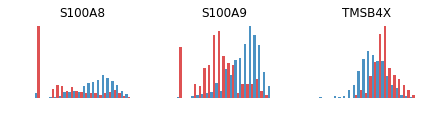

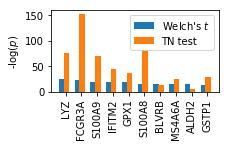

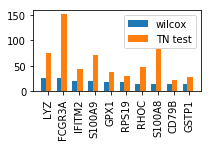

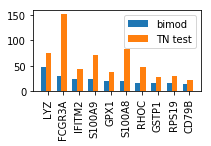

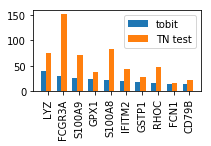

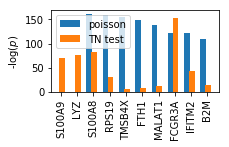

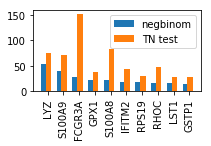

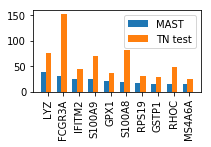

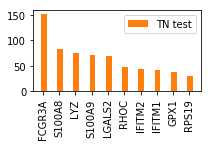

In [10]:
np.random.seed(0)
ident0, ident1 = 2, 5
_ = compare_clusters_multiple_runs_less_genes(ident0, ident1)
p_tn = compare_clusters_tn_test(ident0, ident1)

create_and_save_visualization(p_tn, ident0, ident1, None, ngenes=10)

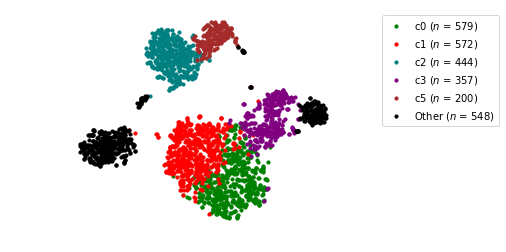

In [11]:
ident0 = 0
ident1 = 1
ident2 = 2
ident3 = 3
ident4 = 5

labels_ = np.array(labels).astype(str)
labels_[~((labels == ident0) | (labels == ident1) | (labels == ident2) 
          | (labels == ident3) | (labels == ident4))] = 'Other'
plt.scatter(tsne[labels_ == str(ident0), 0], tsne[labels_ == str(ident0), 1],
            label=r'c%s ($n$ = %s)'%(ident0, np.sum(labels_== str(ident0))), c='g', s=10)
plt.scatter(tsne[labels_ == str(ident1), 0], tsne[labels_ == str(ident1), 1],
            label=r'c%s ($n$ = %s)'%(ident1, np.sum(labels_== str(ident1))), c='r', s=10)
plt.scatter(tsne[labels_ == str(ident2), 0], tsne[labels_ == str(ident2), 1],
            label=r'c%s ($n$ = %s)'%(ident2, np.sum(labels_== str(ident2))), c='teal', s=10)   
plt.scatter(tsne[labels_ == str(ident3), 0], tsne[labels_ == str(ident3), 1],
            label=r'c%s ($n$ = %s)'%(ident3, np.sum(labels_== str(ident3))), c='purple', s=10)    
plt.scatter(tsne[labels_ == str(ident4), 0], tsne[labels_ == str(ident4), 1],
            label=r'c%s ($n$ = %s)'%(ident4, np.sum(labels_== str(ident4))), c='brown', s=10)    
plt.scatter(tsne[labels_ == 'Other', 0], tsne[labels_ == 'Other', 1],
            label=r'Other ($n$ = %s)'%(np.sum(labels_=='Other')), c='k', s=10)
plt.legend(bbox_to_anchor=(1.4, 1))
plt.axis('equal')
plt.axis('off')
plt.savefig('figures/pbmc_tsne_supp.pdf',
            format='pdf', dpi=500, bbox_inches='tight')
plt.show()    